In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import datetime as dt

## Load input data

In [4]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
vot_p=vot_p/np.sum(vot_p)

## Travel time functions

In [5]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

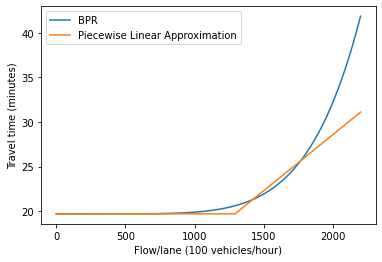

In [6]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

## Generate demand profile

In [7]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 45.0 $/hr; median: 37.2 $/hr


In [8]:
# vot_all_days[-1, :]

Text(0, 0.5, '% of population')

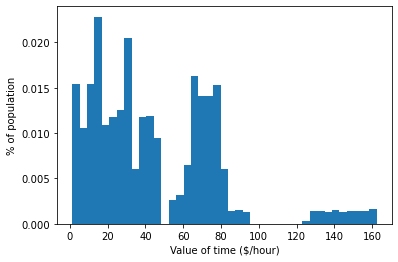

In [9]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

## Define Social Objectives of Interest

In [10]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.24
23.28
30.09
37.33
44.17
63.72
68.94
74.93
80.31
162.26


In [11]:
demand_multiplier = [25,75]

###### Evaluate Travel Time Metrics ###### 
def evaluate_avg_tt_in(solution_, demand_multiplier):
    """
    Average travel time, ineligible only
    """
    ineligible_tt = sum(solution_['users_in'][k, i, j]*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                                    capacity = bpr_true_capacity*demand_multiplier[i],
                                                                    b = apx_slope/demand_multiplier[i])
                                 for k in range(num_ineligible) for i in range(2) for j in range(T))/(T*num_ineligible)
    return ineligible_tt

def evaluate_avg_tt_el(solution_, demand_multiplier):
    """
    Average travel time, eligible only
    """
    
    eligible_tt = sum((solution_['users_el'][ i, j]/num_eligible)*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                               capacity = bpr_true_capacity*demand_multiplier[i],
                                                               b = apx_slope/demand_multiplier[i])
                                for i in range(2) for j in range(T) )/(T*num_eligible)
    return eligible_tt

def evaluate_total_tt(solution_,demand_multiplier):
    """
    Total travel time  
    """
    ineligible_tt = evaluate_avg_tt_in(solution_, demand_multiplier)*num_ineligible*T
    eligible_tt = evaluate_avg_tt_el(solution_, demand_multiplier)*num_eligible*T
    
    return eligible_tt + ineligible_tt

def evaluate_avg_travel_time(solution_,demand_multiplier):
    """
    Average travel time  
    """
    return evaluate_total_tt(solution_,demand_multiplier)/(T*num_total)

def evaluate_avg_express_tt(solution_,demand_multiplier):
    """
    Average travel time on express lane
    """
    avg_EL_tt = sum(apx_bpr_cost(solution_['edge_flows'][0, j],capacity = bpr_true_capacity*demand_multiplier[0],
                                 b = apx_slope/demand_multiplier[0]) for j in range(T))/T
    return avg_EL_tt

def evaluate_avg_general_tt(solution_,demand_multiplier):
    """
    Average travel time on general purpose lanes
    """
    avg_GP_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, j],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) for j in range(T))/T
    return avg_GP_tt
    
def evaluate_avg_tt_savings(solution_,demand_multiplier):
    """
    Average travel time savings   
    """
    delta_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, j],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) - 
                   apx_bpr_cost(solution_['edge_flows'][0, j],capacity = bpr_true_capacity*demand_multiplier[0],
                                b = apx_slope/demand_multiplier[0])  for j in range(T))/T
    return delta_tt

###### Evaluate Lane Usage Metrics ###### 
def evaulate_express_usage(solution_,demand_multiplier):
    """
    Average share of all/el/inel users using express lane
    """
    share_eligible = sum(solution_['users_el'][ 0, j] for j in range(T))/(T*num_eligible)
    share_ineligible = sum(solution_['users_in'][k, 0, j] for k in range(num_ineligible) for j in range(T))/(T*num_ineligible)
    share_all = (sum(solution_['users_el'][ 0, j] for j in range(T))+
               sum(solution_['users_in'][k, 0, j] for k in range(num_ineligible) for j in range(T)))/(T*(num_total))
    return share_all, share_eligible, share_ineligible

def evaluate_express_usage_percentile_inel(solution_,demand_multiplier,percentiles):
    share_ineligible={}
    for p,thresh in percentiles.items():
        # number of ineligible users in the group
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0]) for j in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60)))[0]) for j in range(T))
        
        share_ineligible[p]=0
        for j in range(T):
            if p>=10:
                share_ineligible[p]+=sum(solution_['users_in'][k, 0, j] 
                                         for k in np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                           (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0])
            else:
                share_ineligible[p]+=sum(solution_['users_in'][k, 0, j] 
                                         for k in np.where((vot_ineligible[:,j]<=(thresh/60)))[0])
        if these_ineligible>0:
            share_ineligible[p]=share_ineligible[p]/these_ineligible
    return share_ineligible

###### Evaluate Travel Cost Metrics ###### 
def evaluate_total_travel_cost_in(solution_, tau, demand_multiplier):
    """
    Total travel cost for ineligible only
    """
    ineligible_travel_cost = sum(solution_['users_in'][k, i, j]*vot_ineligible[k, j]*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[i],
                                                                                                  b = apx_slope/demand_multiplier[i])
                                 for k in range(num_ineligible) for i in range(2) for j in range(T))
    toll_revenue = evaulate_total_revenue(solution_, tau, demand_multiplier)
    return ineligible_travel_cost + toll_revenue

def evaluate_total_travel_cost_el(solution_, tau, demand_multiplier):
    """
    Total travel cost for eligible only
    """
    eligible_travel_cost = sum((solution_['users_el'][ i, j]/num_eligible)*vot_eligible[k, j]*apx_bpr_cost(solution_['edge_flows'][i, j],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[i],
                                                                                                           b = apx_slope/demand_multiplier[i])  
                               for k in range(num_eligible) for i in range(2) for j in range(T))
    return eligible_travel_cost

def evaulate_total_revenue(solution_, tau, demand_multiplier):
    """
    Total toll revenue   
    """
    total_toll_revenue = sum(tau*solution_['users_in'][k, 0, j] for k in range(num_ineligible) for j in range(T))
    return total_toll_revenue

def evaluate_total_travel_cost_percentile_inel(solution_,tau,demand_multiplier,percentiles):
    """
    Total travel cost for each ineligible group percentile
    """
    social_cost={}
    for p,thresh in percentiles.items():
        social_cost[p]=0
        for j in range(T):
            if p>=10:
                social_cost[p]+=sum(solution_['users_in'][k, i, j]*vot_ineligible[k, j]*apx_bpr_cost(
                    solution_['edge_flows'][i, j],capacity = bpr_true_capacity*demand_multiplier[i], b = apx_slope/demand_multiplier[i]) 
                                    for k in np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                      (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0] for i in range(2))
                
                social_cost[p]+=sum(solution_['users_in'][k, 0, j]*tau for k in np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                                                         (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0] )
            else:
                social_cost[p]+=sum(solution_['users_in'][k, i, j]*vot_ineligible[k, j]*apx_bpr_cost(
                    solution_['edge_flows'][i, j],capacity = bpr_true_capacity*demand_multiplier[i],b = apx_slope/demand_multiplier[i])
                                    for k in np.where((vot_ineligible[:,j]<=(thresh/60)))[0] for i in range(2))
                social_cost[p]+=sum(solution_['users_in'][k, 0, j]*tau for k in np.where((vot_ineligible[:,j]<=(thresh/60)))[0])
    return social_cost

def evaluate_avg_travel_cost_percentile_inel(social_cost_by_percentile):
    """
    Average travel cost for each ineligible group percentile  
    """
    avg_social_cost={}
    for p,thresh in percentiles.items():
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60))&
                                                (vot_ineligible[:,j]>(percentiles[p-10]/60)))[0]) for j in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,j]<=(thresh/60)))[0]) for j in range(T))
        if these_ineligible>0:
            avg_social_cost[p]=social_cost_by_percentile[p]/these_ineligible
        else:
            avg_social_cost[p]=0
    return avg_social_cost

### Optimization Solver

In [12]:
def mainOptPL(tau, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val')
    edge_flows = m1.addVars(2, T, name = 'edge_flows')
    users_el = m1.addVars(2, T, name = 'eligible_allocation')
    
    # Add variables for piecewise affine approximation
    eps_flows = m1.addVars(2, T, name = 'eps_flows')

    # Add constraints to Model
    m1.addConstrs((edge_flows[i, j] == sum(users_in[k, i, j] for k in range(num_ineligible)) + 
                  users_el[i, j] for i in range(2) for j in range(T)))
    m1.addConstrs((users_in[i, j, k]>=0 for i in range(num_ineligible) for j in range(2) for k in range(T))) # Non-negativity constraints ineligible
    m1.addConstrs((users_in[i, 0, j] + users_in[i, 1, j] == 1 for i in range(num_ineligible) for j in range(T))) # Allocation constraints ineligible
    m1.addConstrs((users_el[0, j] + users_el[1, j] == num_eligible for j in range(T))) # Allocation constraints eligible
    
    if tau != 0:
        m1.addConstr((sum(tau*users_el[0, t] for t in range(T)) <= B*num_eligible))
        
    # Add constraints for piecewise affine approximation
    m1.addConstrs((eps_flows[j, k] >= 0 for j in range(2) for k in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, k] >= edge_flows[0, k] - cap_thresh*c_1 for k in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, k] >= edge_flows[1, k] - cap_thresh*c_2 for k in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0,t]) + b_1*(eps_flows[0, t]**2)/2
                        +a*fftt_2*(edge_flows[1,t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( tau*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [13]:
def _extract_solution(m):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

## Solve Optimization for Discretized Grid

In [14]:
###### Initialize matrices for results ###### 
# Optimization problems are iterated over tolls budgets

avg_tt_in = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_el = np.zeros((len(tau_arr), len(B_arr)))
total_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_EL_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_GP_tt = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_savings = np.zeros((len(tau_arr), len(B_arr)))

exp_all = np.zeros((len(tau_arr), len(B_arr)))
exp_el = np.zeros((len(tau_arr), len(B_arr)))
exp_in = np.zeros((len(tau_arr), len(B_arr)))
exp_in_p = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

total_tc_in=np.zeros((len(tau_arr), len(B_arr)))
total_tc_el= np.zeros((len(tau_arr), len(B_arr)))
total_tr= np.zeros((len(tau_arr), len(B_arr)))
total_tc_in_p= {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}
avg_tc_in_p= {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

In [32]:
print("tau_arr:", tau_arr)
print()
print("B_arr:", B_arr)

tau_arr: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B_arr: [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]


In [33]:
tau_arr = [0.0, 1.0, 2.0]
B_arr = [0.0, 5.0, 10.0]

In [34]:
###### Solve optimization and evaluate social cost for each CBCP ######

count = 0
total_count = len(tau_arr)*len(B_arr)
start_time = dt.datetime.now()
this_time = start_time
for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        if (100*np.round(count/total_count,2))%10==0:
            print("PROGRESS: {}% complete, time since start: {}".format(100*np.round(count/total_count,2),dt.datetime.now()-start_time))
        count+=1
        
        # Initialize Optimization Problem
        m1 = mainOptPL(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        # Solve optimization problem
        m1.optimize()
        
        print(m1.status != GRB.OPTIMAL)
        
        if m1.status == 3:
            continue
        
        # Extract Solution
        solution_set = _extract_solution(m1)
        
        if toll == tau_arr[0]:
            print(solution_set['edge_flows'])
        
        # Evaluate metrics
        avg_tt_in[toll_idx, budget_idx] = evaluate_avg_tt_in(solution_set, demand_multiplier)
        avg_tt_el[toll_idx, budget_idx] = evaluate_avg_tt_el(solution_set, demand_multiplier)
        total_tt[toll_idx, budget_idx] = evaluate_total_tt(solution_set,demand_multiplier)
        avg_tt[toll_idx, budget_idx] = evaluate_avg_travel_time(solution_set,demand_multiplier)
        avg_EL_tt[toll_idx, budget_idx] = evaluate_avg_express_tt(solution_set,demand_multiplier)
        avg_GP_tt[toll_idx, budget_idx] = evaluate_avg_general_tt(solution_set,demand_multiplier)
        avg_tt_savings[toll_idx, budget_idx] = evaluate_avg_tt_savings(solution_set,demand_multiplier)

        exp_all[toll_idx, budget_idx], exp_el[toll_idx, budget_idx], exp_in[toll_idx, budget_idx] = evaulate_express_usage(solution_set,demand_multiplier)

        total_tc_in[toll_idx, budget_idx] = evaluate_total_travel_cost_in(solution_set, toll, demand_multiplier)
        total_tc_el[toll_idx, budget_idx] = evaluate_total_travel_cost_el(solution_set, toll, demand_multiplier)
        total_tr[toll_idx, budget_idx] = evaulate_total_revenue(solution_set, toll, demand_multiplier)
        
        share_inel_all = evaluate_express_usage_percentile_inel(solution_set,demand_multiplier,percentiles)
        total_social_cost_inel_all = evaluate_total_travel_cost_percentile_inel(solution_set,toll,demand_multiplier,percentiles)
        avg_social_cost_inel_all = evaluate_avg_travel_cost_percentile_inel(total_social_cost_inel_all)
        for p in range(11):
            exp_in_p[p*10][toll_idx,budget_idx] = share_inel_all[p*10]
            total_tc_in_p[p*10][toll_idx,budget_idx] = total_social_cost_inel_all[p*10]
            avg_tc_in_p[p*10][toll_idx,budget_idx] = avg_social_cost_inel_all[p*10]

PROGRESS: 0.0% complete, time since start: 0:00:00.000545
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99635 rows, 66430 columns and 199260 nonzeros
Model fingerprint: 0x0f9e5cba
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 99625 rows and 66415 columns
Presolve time: 0.11s
Presolved: 10 rows, 15 columns, 20 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal


Barrier solved model in 24 iterations and 0.30 seconds (0.22 work units)
Optimal objective 8.57887400e+05

False
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x92935acc
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 99626 rows and 33215 columns
Presolve time: 0.11s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration


Optimize a model with 99636 rows, 66430 columns and 199265 nonzeros
Model fingerprint: 0x2014ffe7
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 99626 rows and 33220 columns
Presolve time: 0.10s
Presolved: 10 rows, 33210 columns, 66410 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.79096817e+08 -6.48093338e+06  6.64e+06 5.68e-14  1.00e+06     0s
   1   1.15093168e+06 -4.18763661e+06  5.94e+03 9.09e-13  1.08e+03     0s
   2   1.05088729e+06 -2.85705371e+0

  25   8.53892378e+05  8.53839859e+05  0.00e+00 2.84e-14  7.91e-04     0s
  26   8.53889261e+05  8.53843566e+05  0.00e+00 2.13e-14  6.88e-04     0s
  27   8.53886275e+05  8.53847080e+05  0.00e+00 2.84e-14  5.90e-04     0s
  28   8.53884789e+05  8.53849020e+05  0.00e+00 2.13e-14  5.38e-04     0s
  29   8.53882671e+05  8.53851638e+05  0.00e+00 2.84e-14  4.67e-04     0s
  30   8.53880608e+05  8.53854029e+05  0.00e+00 2.13e-14  4.00e-04     0s
  31   8.53878266e+05  8.53856833e+05  0.00e+00 1.42e-14  3.23e-04     0s
  32   8.53877283e+05  8.53857992e+05  0.00e+00 1.42e-14  2.90e-04     0s
  33   8.53876456e+05  8.53858941e+05  0.00e+00 1.42e-14  2.64e-04     0s
  34   8.53874735e+05  8.53860858e+05  0.00e+00 1.42e-14  2.09e-04     0s
  35   8.53874533e+05  8.53861140e+05  0.00e+00 2.84e-14  2.02e-04     0s
  36   8.53872946e+05  8.53862935e+05  0.00e+00 2.84e-14  1.51e-04     0s
  37   8.53870667e+05  8.53865438e+05  0.00e+00 2.84e-14  7.87e-05     0s
  38   8.53869987e+05  8.53866164e+05 

In [35]:
share_inel_all

{0: 0, 10: 0, 20: 0, 30: 0, 40: 0, 50: 0, 60: 0, 70: 0, 80: 0, 90: 0, 100: 0}

### Plotting

In [16]:
from mpl_toolkits.mplot3d import Axes3D

def side_by_side_figs(x,y,z_list,x_lab,y_lab,z_lab_list,filename,dimensions='3d',dim_range = None, textSize=18):
    """
    Produce and save heatmap plots; either 3D or 2D
    Can produce up to 4 plots side-by-side with same color scale
    ** all final plots in paper were flat 2D: dimensions='2df'
    """
    plt.rc('font', size=textSize) #controls default text size
    plt.rc('axes', titlesize=textSize) #fontsize of the axes title
    plt.rc('axes', labelsize=textSize) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=textSize) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=textSize) #fontsize of the y tick labels
    plt.rc('legend', fontsize=textSize) #fontsize of the legend
    
    if len(z_list)==1:
        ax_1=111
    elif len(z_list)==2:
        ax_1=121
        ax_2=122
    elif len(z_list)==3:
        ax_1=131
        ax_2=132
        ax_3=133
    else:
        ax_1=141
        ax_2=142
        ax_3=143
        ax_4=144
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    mappable.set_array(z_list[0])
    min_val=min([z.min() for z in z_list])
    max_val=max([z.max() for z in z_list])
    if dim_range is not None:
         mappable.set_clim(dim_range[0],dim_range[1]) # optional
    else:
        mappable.set_clim(min_val,max_val) # optional

    fig = plt.figure(figsize=(7*len(z_list),7))
    
    if dimensions !='2df':
        ax1 = fig.add_subplot(ax_1, projection='3d')
        ax1.plot_surface(x,y,z_list[0], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
    else:
        ax1 = fig.add_subplot(ax_1)
        ax1.imshow(z_list[0],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
    
    if dimensions=='2d':
        ax1.view_init(90,270)
        cb = fig.colorbar(mappable,ax=ax1, shrink=0.5) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
    elif dimensions =='2df':
        cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
        plt.rcParams.update({'font.size': textSize})
    else:
        ax1.set_zlabel(z_lab_list[0], fontsize=textSize)
    if dimensions !='2df':
        ax1.set_xlabel(x_lab, fontsize=textSize)
        ax1.set_ylabel(y_lab, fontsize=textSize)
    else:
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        
    if len(z_list)>1:
        if dimensions !='2df':
            ax2 = fig.add_subplot(ax_2, projection='3d')
            ax2.plot_surface(x,y,z_list[1], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax2 = fig.add_subplot(ax_2)
            ax2.imshow(z_list[1],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
        if dimensions=='2d':
            ax2.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax2, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=12)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax2.set_zlabel(z_lab_list[1], fontsize=textSize)
        ax2.set_xlabel(x_lab, fontsize=textSize)
        ax2.set_ylabel(y_lab, fontsize=textSize)
            
    if len(z_list)>2:
        if dimensions !='2df':
            ax3 = fig.add_subplot(ax_3, projection='3d')
            ax3.plot_surface(x,y,z_list[2], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax3 = fig.add_subplot(ax_3)
            ax3.imshow(z_list[2],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)

        if dimensions=='2d':
            ax3.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax3, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax3.set_zlabel(z_lab_list[2], fontsize=textSize)
        ax3.set_xlabel(x_lab, fontsize=textSize)
        ax3.set_ylabel(y_lab, fontsize=textSize)
        
    if len(z_list)>3:
        ax4 = fig.add_subplot(ax_4, projection='3d')
        ax4.plot_surface(x,y,z_list[3], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        if dimensions=='2d':
            ax4.view_init(90,270)
        ax4.set_xlabel(x_lab, fontsize=textSize)
        ax4.set_ylabel(y_lab, fontsize=textSize)
        ax4.set_zlabel(z_lab_list[3], fontsize=textSize)
    
    plt.savefig('{}.png'.format(filename),bbox_inches='tight')

In [17]:
###### Check ranges of metrics ######
print("Travel times at (0,0): {} (express) & {} (non-express)".format(np.round(avg_EL_tt[0,0],1),np.round(avg_GP_tt[0,0],1)))
print("Range expresss travel time: {} to {}".format(np.round(np.min(avg_EL_tt),1),np.round(np.max(avg_EL_tt)),1))
print("Range non-expresss travel time: {} to {}".format(np.round(np.min(avg_GP_tt),1),np.round(np.max(avg_GP_tt)),1))
print("Range overall travel time: {} to {}".format(np.round(np.min(avg_tt),2),np.round(np.max(avg_tt)),2))

print("Range eligible travel time: {} to {}".format(np.round(np.min(avg_tt_el),1),np.round(np.max(avg_tt_el)),1))
print("Range ineligible travel time: {} to {}".format(np.round(np.min(avg_tt_in),1),np.round(np.max(avg_tt_in)),1))

print("Range expresss share: {} to {} (overall); {} to {} (eligible); {} to {} (ineligible)".format(np.round(np.min(100*exp_all),0),np.round(np.max(100*exp_all),0),
                                                                                                   np.round(np.min(100*exp_el),0),np.round(np.max(100*exp_el),0),
                                                                                                   np.round(np.min(100*exp_in),0),np.round(np.max(100*exp_in),0)))
print("Expresss share at (0,0):{} (overall); {}(eligible); {} (ineligible)".format(np.round(100*exp_all[0,0],0),np.round(100*exp_el[0,0],0),np.round(100*exp_in[0,0],0)))


Travel times at (0,0): 28.6 (express) & 28.6 (non-express)
Range expresss travel time: 19.7 to 29.0
Range non-expresss travel time: 28.6 to 35.0
Range overall travel time: 23.67 to 28.0
Range eligible travel time: 0.0 to 0.0
Range ineligible travel time: 28.5 to 33.0
Range expresss share: 7.0 to 25.0 (overall); 0.0 to 100.0 (eligible); 3.0 to 29.0 (ineligible)
Expresss share at (0,0):25.0 (overall); 60.0(eligible); 18.0 (ineligible)


In [18]:
x_plot, y_plot = np.meshgrid(tau_arr,B_arr) # prepare x,y axes

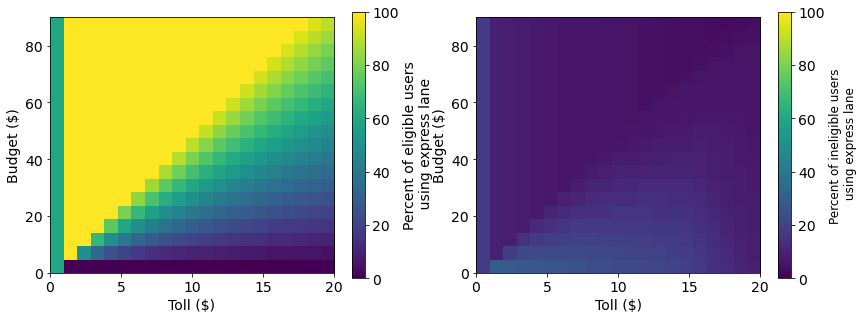

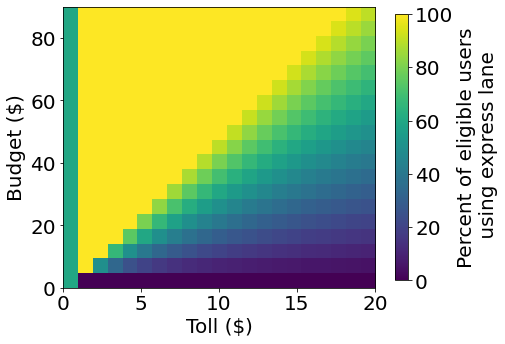

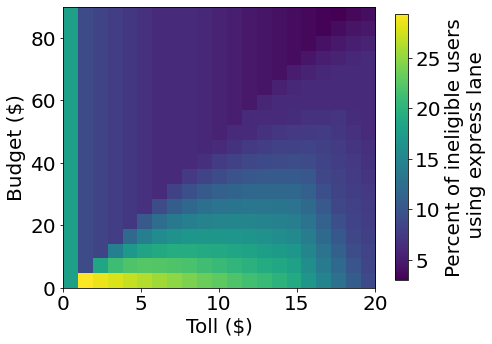

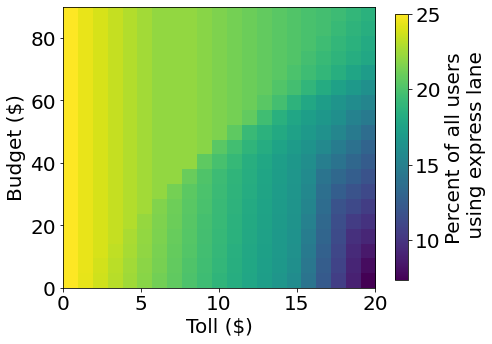

In [19]:
###### Fractions of users on the express lane ######
side_by_side_figs(x_plot,y_plot,[100*exp_el.T,100*exp_in.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane","Percent of ineligible users\n using express lane"],
                  'ExpressSharesELIN_2d',dimensions='2df',textSize=14)
side_by_side_figs(x_plot,y_plot,[100*exp_el.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane"],'ExpressSharesEL_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[100*exp_in.T],'Toll ($)','Budget ($)',
                  ["Percent of ineligible users\n using express lane"],'ExpressSharesIN_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[100*exp_all.T],'Toll ($)','Budget ($)',
                  ["Percent of all users\n using express lane"],'ExpressShareAll_2d',dimensions='2df',textSize=20)

In [20]:
###### Fractions of ineligible users on the express lane by decile ######
for p in range(1,11):
    side_by_side_figs(x_plot,y_plot,[100*share_inel[10*p].T],'Toll','Budget',
                  ["Percent of the {}th decile\nof ineligible users\n using express lane".format(p)],'ExpressSharesINP{}_2d'.format(p),dimensions='2df')

NameError: name 'share_inel' is not defined

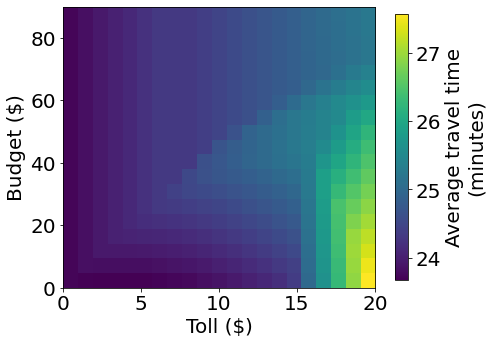

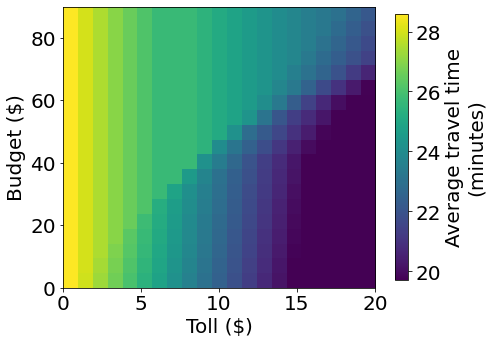

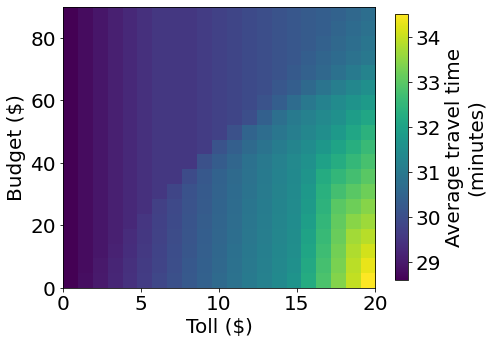

In [21]:
###### Average travel times ######
side_by_side_figs(x_plot,y_plot,[avg_tt.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'Avg_TravelTime_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[avg_EL_tt.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'AvgTravelTimesE_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[avg_GP_tt.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'AvgTravelTimesNE_2d',dimensions='2df',textSize=20)

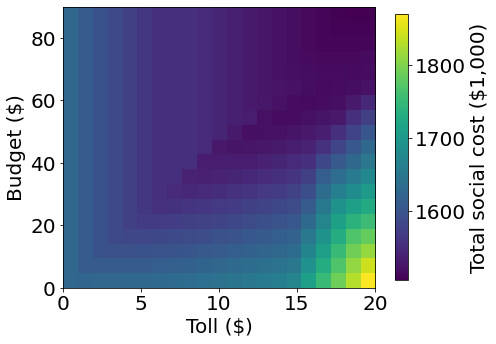

In [22]:
###### Pareto-weighted objective functions ######
weight_e = 35
weight_i = 1
weight_t = 1
z_labels={"1_0_0":"Total travel cost ($1,000)\nEligible users",
         "0_1_0":"Total travel cost ($1,000)\nIneligible users",
         "0_0_1":"Negative total toll revenue\n($1,000)",
         "1_1_1":"Total social cost ($1,000)",
         "5_1_1":"Total social cost ($1,000)",
          "10_1_1":"Total social cost ($1,000)",
         "11_1_1":"Total social cost ($1,000)",
         "12_1_1":"Total social cost ($1,000)",
         "15_1_1":"Total social cost ($1,000)","35_1_1":"Total social cost ($1,000)"}
side_by_side_figs(x_plot,y_plot,[((weight_i*total_tc_in.T)+(weight_e*total_tc_el.T)-(weight_t*total_tr.T))/1000],
                  'Toll ($)','Budget ($)',[z_labels["{}_{}_{}".format(weight_e,weight_i,weight_t)]],
                  'Total SWEL{}IN{}_TR{}_2d'.format(weight_e,weight_i,weight_t),dimensions='2df',textSize=20)

In [23]:
###### Compute optimal CBCP & metrics for various weigthing schemes ######
t_ix=0
b_ix=0
t=int(tau_arr[t_ix])
b=int(B_arr[b_ix])
weight_e = 1
weight_i = 1
weight_t = 1

this_df = []

for weight_e in range(21):
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in[i])+(weight_e*total_tc_el[i])-(weight_t*total_tr[i]))==np.min(
                        ((weight_i*total_tc_in)+(weight_e*total_tc_el)-(weight_t*total_tr))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in[t_ix,b_ix]+total_tc_el[t_ix,b_ix]+total_tr[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt[t_ix,b_ix],1)
            this_df.append(this_row)
            
for s in [[1,0,0],[0,1,0],[0,0,1]]:
    weight_e = s[0]
    weight_i = s[1]
    weight_t = s[2]
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in[i])+(weight_e*total_tc_el[i])-(weight_t*total_tr[i]))==np.min(
                        ((weight_i*total_tc_in)+(weight_e*total_tc_el)-(weight_t*total_tr))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in[t_ix,b_ix]+total_tc_el[t_ix,b_ix]+total_tr[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt[t_ix,b_ix],1)
            this_df.append(this_row)

this_df=pd.DataFrame.from_records(this_df)
this_df

,weight_e,weight_i,weight_t,toll,budget,ExpShare_All,ExpShare_El,ExpShare_In,TotalGenCost_All,TotalGenCost_El,TotalGenCost_In,TotalTR,AvgTT_Express,AvgTT_GP
0,0,1,1,13,0,17.0,0.0,21.0,995349.52,24659.48,881296.74,89393.30,20.7,31.2
1,1,1,1,13,0,17.0,0.0,21.0,995349.52,24659.48,881296.74,89393.30,20.7,31.2
2,2,1,1,13,0,17.0,0.0,21.0,995349.52,24659.48,881296.74,89393.30,20.7,31.2
3,3,1,1,12,0,18.0,0.0,21.0,987189.82,24510.67,877463.90,85215.26,21.3,31.0
4,4,1,1,12,0,18.0,0.0,21.0,987189.82,24510.67,877463.90,85215.26,21.3,31.0
5,5,1,1,12,0,18.0,0.0,21.0,987189.82,24510.67,877463.90,85215.26,21.3,31.0
6,6,1,1,11,0,18.0,0.0,22.0,978614.27,24360.55,873644.56,80609.17,21.9,30.8
7,7,1,1,11,0,18.0,0.0,22.0,978614.27,24360.55,873644.56,80609.17,21.9,30.8
8,8,1,1,11,0,18.0,0.0,22.0,978614.27,24360.55,873644.56,80609.17,21.9,30.8
9,9,1,1,10,0,19.0,0.0,23.0,969636.25,24208.71,869852.16,75575.38,22.4,30.6


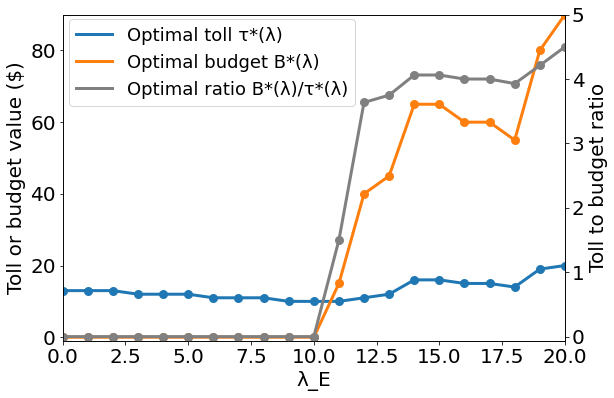

In [24]:
###### Plot optimal CBCP parameters with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3,label='Optimal toll τ*(λ)')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3,label='Optimal budget B*(λ)')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,label='Optimal ratio B*(λ)/τ*(λ)',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Toll or budget value ($)")
ax2.set_ylabel('Toll to budget ratio')
fig.legend(bbox_to_anchor=(0.09, 0.02, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 90))
ax2.set(xlim=(0,20), ylim=(-0.065, 5))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptTollBudget_weight_E.png',bbox_inches='tight')

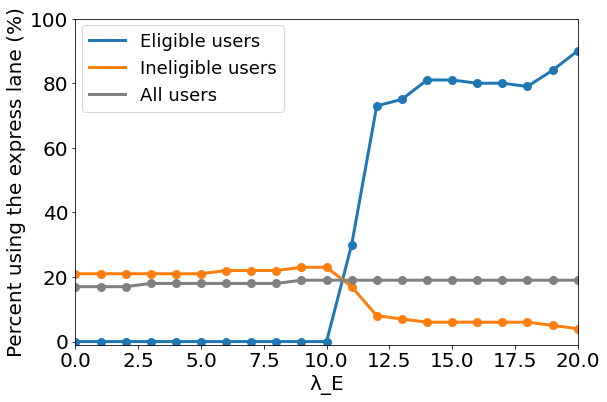

In [25]:
###### Plot optimal CBCP EL usage rates with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3,label='Eligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3,label='Ineligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,label='All users',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Percent using the express lane (%)")
fig.legend(bbox_to_anchor=(-0.04, 0.015, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 100))

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptUserShares_weight_E.png',bbox_inches='tight')

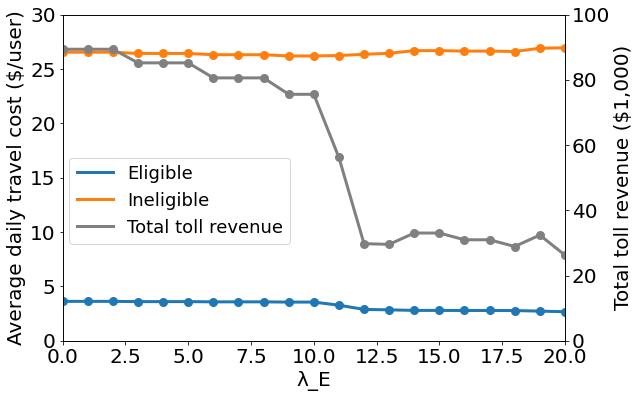

In [26]:
###### Plot optimal CBCP travel cost metrics with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(num_eligible*T),linewidth=3,label='Eligible')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3,label='Ineligible')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,label='Total toll revenue',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(T*num_eligible),linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average daily travel cost ($/user)")
ax2.set_ylabel('Total toll revenue ($1,000)')
fig.legend(bbox_to_anchor=(-0.01, -0.3, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(0, 30))
ax2.set(xlim=(0,20), ylim=(0, 100))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20) 
fig.savefig('OptSocialCosts_weight_E.png',bbox_inches='tight')

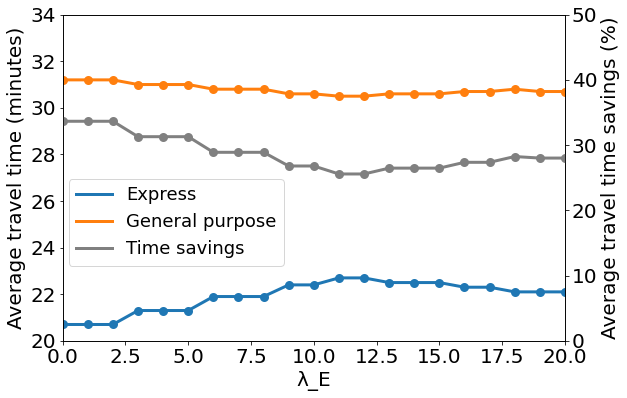

In [27]:
###### Plot optimal CBCP travel times with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3,label='Express')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3,label='General purpose')
ax2.plot(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,label='Time savings',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average travel time (minutes)")
ax2.set_ylabel('Average travel time savings (%)')
fig.legend(bbox_to_anchor=(-0.02, -0.35, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(20, 34))
ax2.set(xlim=(0,20), ylim=(0, 50))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('OptTravelTimes_weight_E.png',bbox_inches='tight')